In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = base.classes.measurement
Station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Climate Analysis

##### 12 month climate analysis

In [116]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
columns = inspector.get_columns('measurement')
for c in columns: 
    print(c['name'], c['type'])

print(f"--------------------------")

latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = list(np.ravel(latest_date))[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------------


datetime.datetime(2017, 8, 23, 0, 0)

In [117]:
# Calculate the date 1 year ago from the last data point in the database
query_date = latest_date - dt.timedelta(days=365)
query_date

datetime.datetime(2016, 8, 23, 0, 0)

In [118]:
# Perform a query to retrieve the data and precipitation scores
# Sort the dataframe by date
# Save the query results as a Pandas DataFrame and set the index to the date column
results = pd.DataFrame(session.query(Measurement.date, Measurement.prcp).\
                      filter(Measurement.date > query_date).\
                      order_by(Measurement.date).all()).set_index('date').sort_index(ascending=True)
results.head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


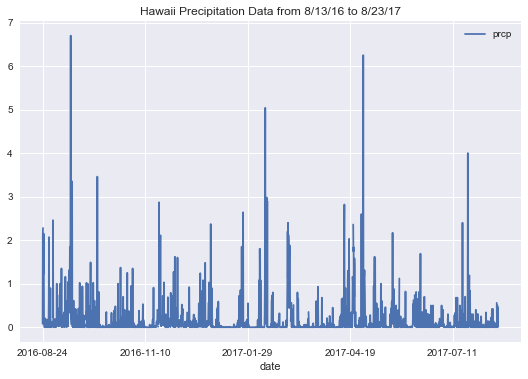

In [119]:
results.plot(title="Hawaii Precipitation Data from 8/13/16 to 8/23/17")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
results.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Station).count() 
print(f'Total stations count: {stations_count}')

Total stations count: 9


In [126]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations_active = (session.query(Measurement.station, func.count(Measurement.station))
                                .group_by(Measurement.station)
                                .order_by(func.count(Measurement.station).desc())
                                .all())
stations_active

for station in stations_active:
    print(f'Station: {station[0]}  Count:{station[1]}')

Station: USC00519281  Count:2772
Station: USC00519397  Count:2724
Station: USC00513117  Count:2709
Station: USC00519523  Count:2669
Station: USC00516128  Count:2612
Station: USC00514830  Count:2202
Station: USC00511918  Count:1979
Station: USC00517948  Count:1372
Station: USC00518838  Count:511


In [132]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = station_active[0][0]

temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                          func.avg(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).all()

print(f"-------------------Most Active Station Data Analysis-------------------")
print(f"Lowest Temperature: {temp_stats[0][0]} Farheniet")
print(f"------------------------------------------------------")
print(f"Highest Temperature: {temp_stats[0][1]} Farheniet")
print(f"------------------------------------------------------")
print(f"Average Temperature: {temp_stats[0][2]} Farheniet")

-------------------Most Active Station Data Analysis-------------------
Lowest Temperature: 54.0 Farheniet
------------------------------------------------------
Highest Temperature: 85.0 Farheniet
------------------------------------------------------
Average Temperature: 71.66378066378067 Farheniet


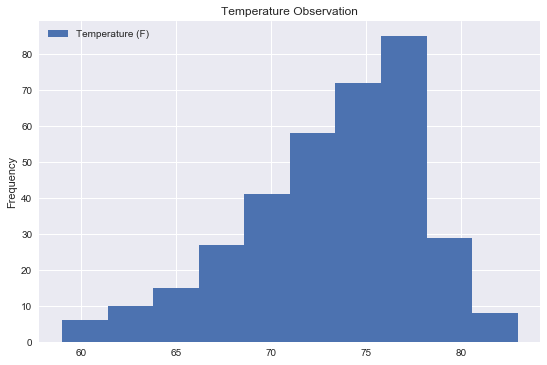

In [135]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_tobs = pd.DataFrame(session.query(Measurement.date, Measurement.tobs)
                        .filter(Measurement.station == most_active_station).\
                        filter(Measurement.date > query_date).\
                        order_by(Measurement.date).\
                        all()).set_index('date')
temp_data = temp_tobs.rename(columns = {"date": "Date",
                                       "tobs": "Temperature (F)"})
temp_data.head()
temp_data.plot(kind="hist", title = "Temperature Observation")

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [128]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = '2017-04-05'
trip_end = '2017-04-15'
trip_temps = calc_temps(trip_start, trip_end )
trip_temps

[(67.0, 74.34782608695652, 82.0)]

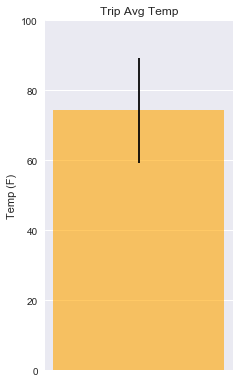

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_trip_temps = trip_temps[0][0]
avg_trip_temps = trip_temps[0][1]
max_trip_temps = trip_temps[0][2]

min_error = avg_trip_temps - min_trip_temps
max_error = max_trip_temps - avg_trip_temps


plt.figure(figsize=(3,6))
plt.bar(0, avg_trip_temps, yerr=[max_trip_temps - min_trip_temps], color='orange', alpha=0.6)
plt.title("Trip Avg Temp")
plt.ylim(0,100)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(Station.station, 
                                func.sum(Measurement.prcp), 
                                Station.name,
                                Station.elevation,
                                Station.latitude,
                                Station.longitude
                                ).filter(Measurement.station == Station.station).\
                                        filter(Measurement.date >= trip_start).\
                                        filter(Measurement.date <= trip_end).\
                                        group_by(Station.station)\
                                        .order_by(func.sum(Measurement.prcp).desc()).all()

data = pd.DataFrame(np.array(total_rainfall))

rainfall_data = data.rename(columns={0: "Station",
                                     1: "prcp",
                                     2: "Address", 
                                     3: "Elevation", 
                                     4: "Latitude",
                                     5: "Longitude"})
rainfall_data

,Station,prcp,Address,Elevation,Latitude,Longitude
0,USC00516128,5.300000000000001,"MANOA LYON ARBO 785.2, HI US",152.4,21.3331,-157.8025
1,USC00519281,3.5799999999999996,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84888999999998
2,USC00513117,1.5199999999999998,"KANEOHE 838.1, HI US",14.6,21.4234,-157.8015
3,USC00514830,0.81,"KUALOA RANCH HEADQUARTERS 886.9, HI US",7.0,21.5213,-157.8374
4,USC00519523,0.36,"WAIMANALO EXPERIMENTAL FARM, HI US",19.5,21.33556,-157.71139
5,USC00519397,0.27,"WAIKIKI 717.2, HI US",3.0,21.2716,-157.8168
6,USC00517948,0.0,"PEARL CITY, HI US",11.9,21.3934,-157.9751


In [109]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [110]:
# calculate the daily normals for your trip
# Set the start and end date of the trip
trip_start = dt.datetime.strptime('2017-04-05', '%Y-%m-%d')
trip_end = dt.datetime.strptime('2017-04-15', '%Y-%m-%d')

# Use the start and end date to create a range of dates
trip_duration = 10 

# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

dates_list = [dt.datetime.strftime(trip_start + dt.timedelta(days = x), '%m-%d')
                            for x in range(0,trip_duration)]

# push each tuple of calculations into a list called `normals`
normals = [daily_normals(date) for date in dates_list]
normals

[[(61.0, 72.28813559322033, 80.0)],
 [(67.0, 71.57142857142857, 77.0)],
 [(63.0, 71.10526315789474, 78.0)],
 [(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)]]

In [111]:
# Load the previous query results into a Pandas DataFrame add the `trip_dates` range as the `date` index
trip_normal = [np.array(normal[0]) for normal in normals]
trip_normal_db = pd.DataFrame(trip_normal)
# Add the `trip_dates` range as the `date` index
trip_normal_db["Date"] = dates_list
trips_normal_db = trip_normal_db.rename(columns={0: "Min Temperature", 
                                                 1: "Average Temperature", 
                                                 2: "Max Temperature"}).set_index("Date")
trips_normal_db

,Min Temperature,Average Temperature,Max Temperature
Date,,,
04-05,61.0,72.288136,80.0
04-06,67.0,71.571429,77.0
04-07,63.0,71.105263,78.0
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0


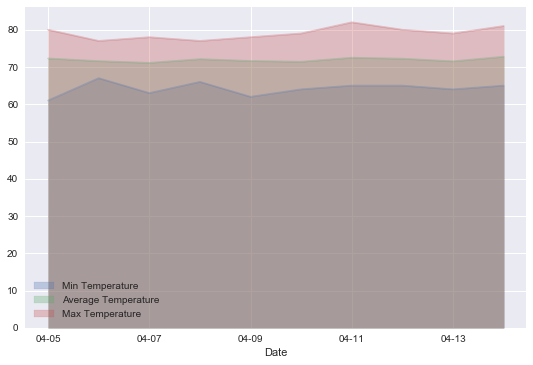

In [115]:
trips_normal_db.plot.area(stacked=False, alpha= .300)